Import necessary libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.decomposition import PCA
import warnings

Load the dataset

In [18]:
df = pd.read_csv('heart.csv')

Display shape, info, describe and others

In [19]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [20]:
df.shape

(918, 12)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [22]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [23]:
df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

In [24]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [25]:
df.isnull().sum().sum()

np.int64(0)

Identifying categorical and numerical columns

In [26]:
categorical_cols = df.select_dtypes(include='object').columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

Checking for outliers using boxplots (numerical columns)

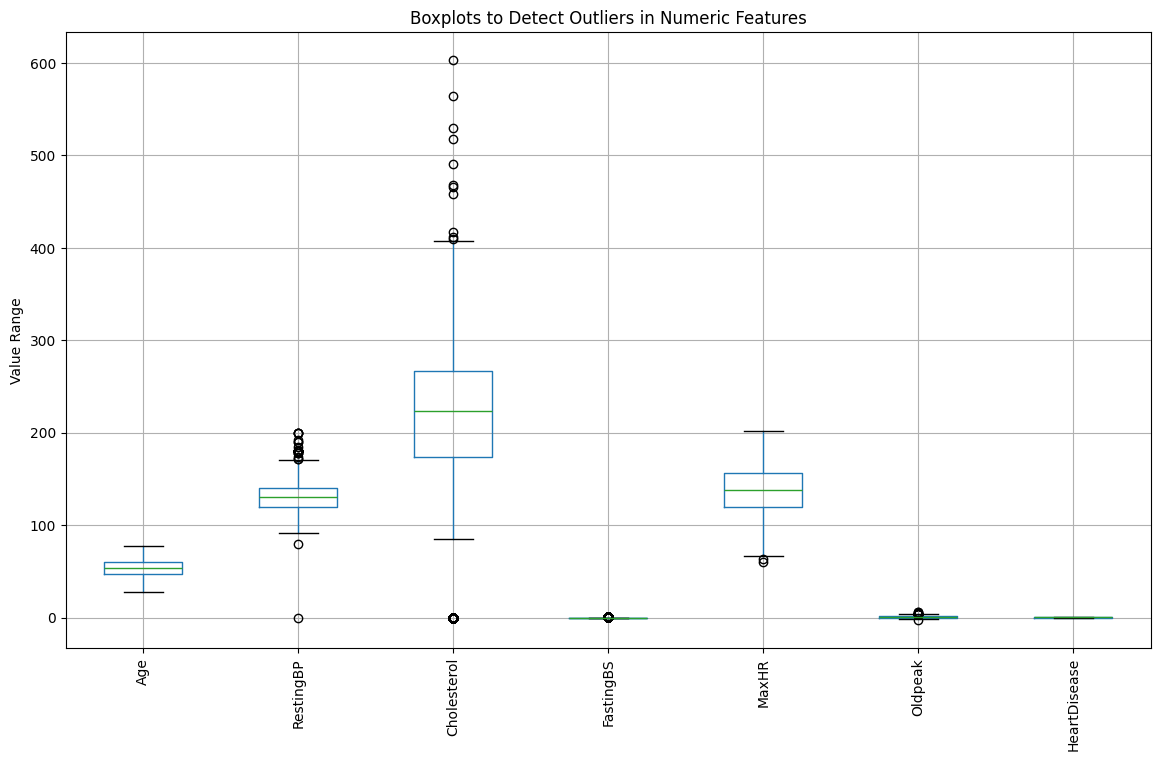

In [27]:
plt.figure(figsize=(14, 8))
df[numerical_cols].boxplot(rot=90)
plt.title("Boxplots to Detect Outliers in Numeric Features")
plt.ylabel("Value Range")
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Boxplots for Selected Numeric Features')

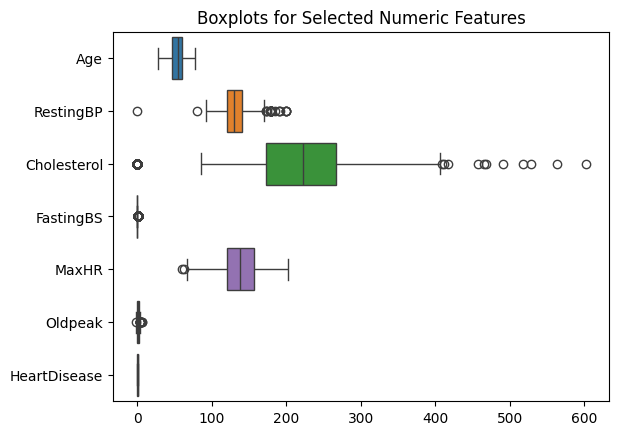

In [28]:
sns.boxplot(data=df[numerical_cols], orient='h')
plt.title("Boxplots for Selected Numeric Features")

Analyzing outliers by skew function

In [30]:
df[numerical_cols].skew()

Age            -0.195933
RestingBP       0.179839
Cholesterol    -0.610086
FastingBS       1.264484
MaxHR          -0.144359
Oldpeak         1.022872
HeartDisease   -0.215086
dtype: float64

<Figure size 1400x800 with 0 Axes>

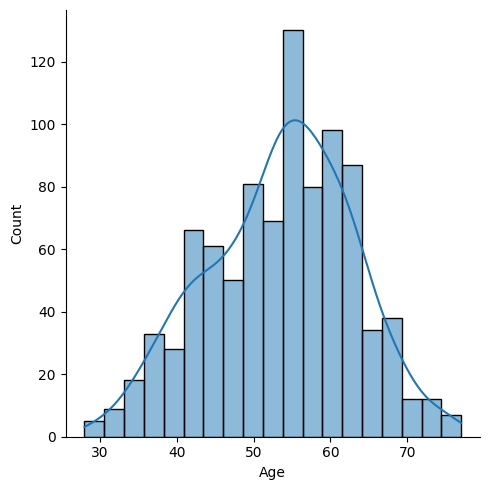

<Figure size 1400x800 with 0 Axes>

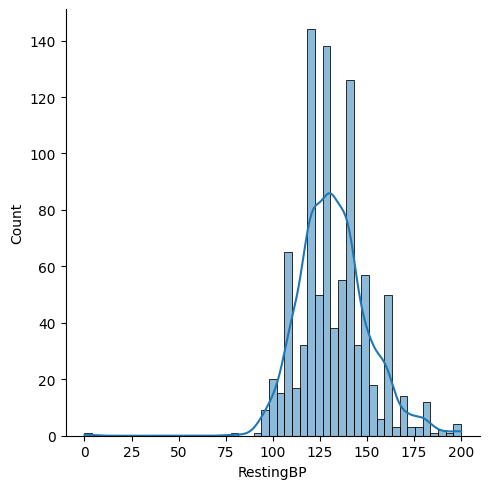

<Figure size 1400x800 with 0 Axes>

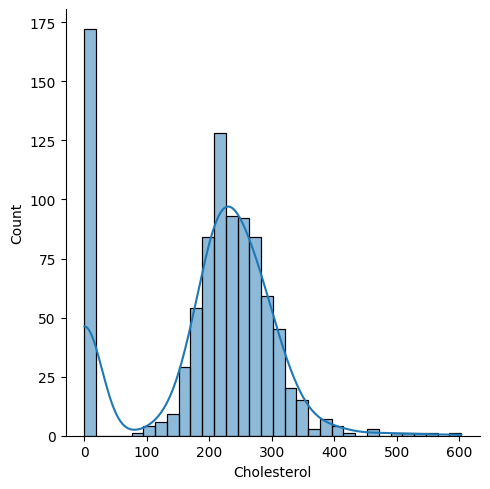

<Figure size 1400x800 with 0 Axes>

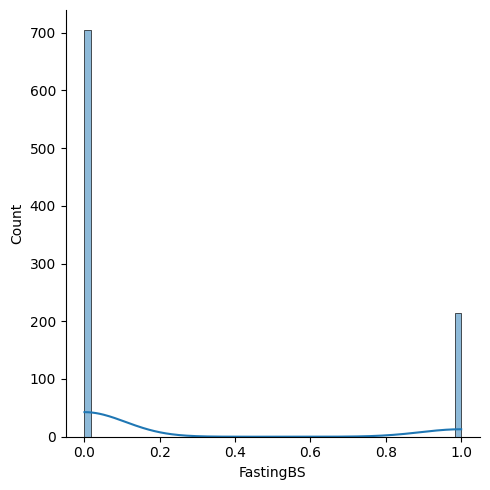

<Figure size 1400x800 with 0 Axes>

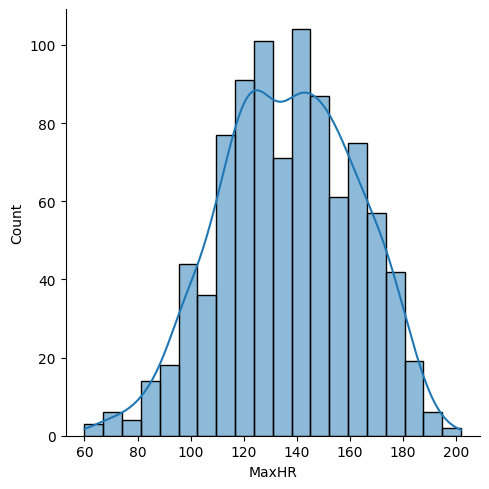

<Figure size 1400x800 with 0 Axes>

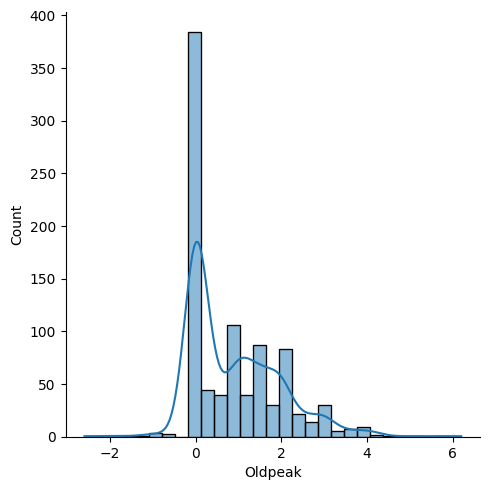

<Figure size 1400x800 with 0 Axes>

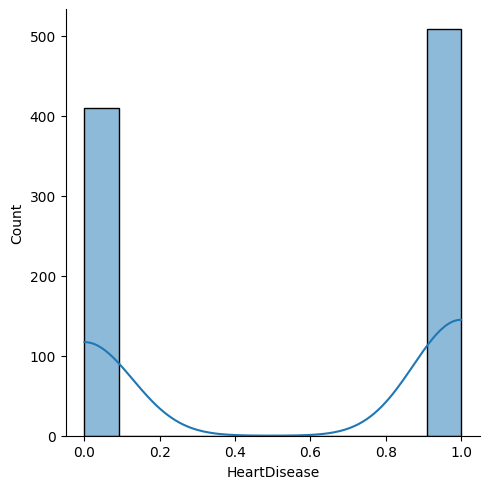

In [31]:
for col in numerical_cols:
    plt.figure(figsize=(14, 8))
    sns.displot(df[col], kde=True)
    plt.show()
 


function for replacing the outliers with the mean value

In [32]:

def replace_outliers_with_mean(df, columns, threshold=1.5):
    
    
    df_clean = df.copy()
    
    for col in columns:
        if col in df.columns:
            # Calculate Q1, Q3 and IQR
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
        
            outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
            
            col_mean = df.loc[~outliers, col].mean()
            
            df_clean.loc[outliers, col] = col_mean
            
            print(f"Column '{col}': Replaced {outliers.sum()} outliers with mean {col_mean:.2f}")
        else:
            print(f"Warning: Column '{col}' not found in dataframe")
    
    return df_clean

separating the outlier columns for sending to the replace_outliers_with_mean function

In [33]:
columns_to_process = ['RestingBP','MaxHR']

In [34]:
df = replace_outliers_with_mean(df, columns_to_process)

Column 'RestingBP': Replaced 28 outliers with mean 131.11
Column 'MaxHR': Replaced 2 outliers with mean 136.97


C:\Users\HP\AppData\Local\Temp\ipykernel_10328\370093384.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '131.1134831460674' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_clean.loc[outliers, col] = col_mean
C:\Users\HP\AppData\Local\Temp\ipykernel_10328\370093384.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '136.97379912663754' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_clean.loc[outliers, col] = col_mean


After replacing the outliers

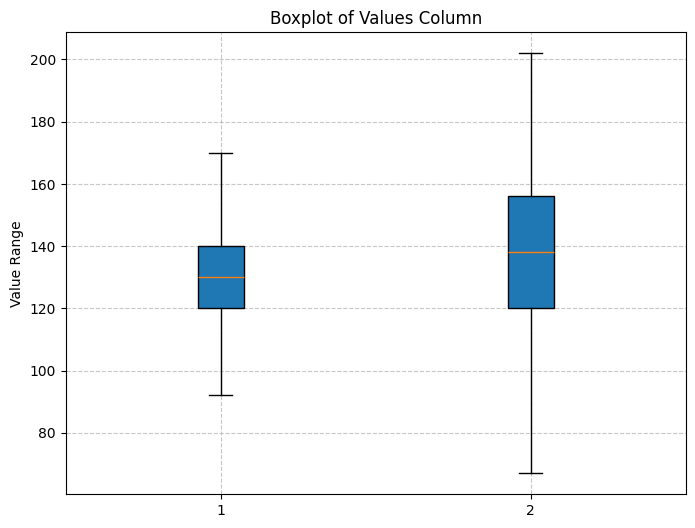

In [35]:
plt.figure(figsize=(8, 6))
plt.boxplot(df[columns_to_process], vert=True, patch_artist=True)
plt.title('Boxplot of Values Column')
plt.ylabel('Value Range')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

function for replacing the outliers with the mode value

In [36]:

def replace_outliers_with_mode(df, columns, threshold=1.5):
    
    
    df_clean2 = df.copy()
    
    for col in columns:
        if col in df.columns:
         
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
                    
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
            
            col_mode = df.loc[~outliers, col].mode()[0]
            
            df_clean2.loc[outliers, col] = col_mode
            
            print(f"Column '{col}': Replaced {outliers.sum()} outliers with mode {col_mode:.2f}")
        else:
            print(f"Warning: Column '{col}' not found in dataframe")
    
    return df_clean2

separating the outlier columns for sending to the replace_outliers_with_mode function

In [37]:
columns_to_process = ['Oldpeak']

In [38]:
df = replace_outliers_with_mode(df, columns_to_process)

Column 'Oldpeak': Replaced 16 outliers with mode 0.00


After replacing the outliers

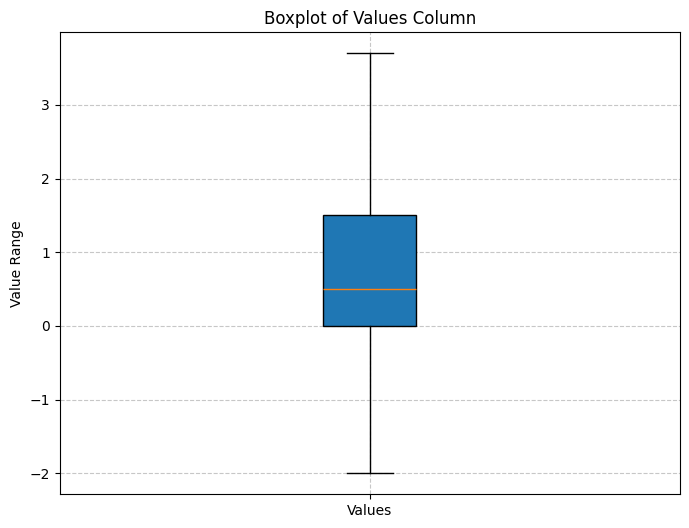

In [39]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['Oldpeak'], vert=True, patch_artist=True)
plt.title('Boxplot of Values Column')
plt.ylabel('Value Range')
plt.xticks([1], ['Values']) 
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()